In [1]:
import numpy
from finance_utils.asset.spot.base import Spot
from finance_utils.process.prices.gbm import RVDecoupledGBM, GBM, NormalDistribution
from finance_utils.trader.base import Trader
from matplotlib import pyplot

from data_utils.stochastic_utils.distributions.nonParametricDistribution import HistogramDist
from easy_datetime.timestamp import TimeStamp
import tqdm

from matplotlib import pyplot

In [2]:
base_trader = Trader("trader", 20000 * 12, "2000-1-1")

In [3]:
stock = Spot("10001", 100, ["day", 0])
# short_stock = Spot("10002", 100)

In [24]:
stock_process = GBM(stock.name, 100, 0, 0.015, 366, "2024-1-1", "day", 1)
multi_pathing = stock_process.multi_pathing(base_trader, stock, 1000)

In [28]:
price_list = []
yield_list = []
for i,t in enumerate(multi_pathing.timeline):
    t:TimeStamp
    price_slice = []
    yield_slice = []
    
    if t.day == 1:
        for j in range(multi_pathing.size[1]):
            path_value = multi_pathing.processes[j].get_price(t)
            stock.purchased_to(multi_pathing.trades[j], path_value.price, 20000, t)
    elif t.day == t.last_day_in_month():
        for j in range(multi_pathing.size[1]):
            path_value = multi_pathing.processes[j].get_price(t)
            yield_slice.append(multi_pathing.trades[j].net_worth_rate(**path_value.dic))
            price_slice.append(path_value.price)
        yield_list.append(yield_slice)
        price_list.append(price_slice)

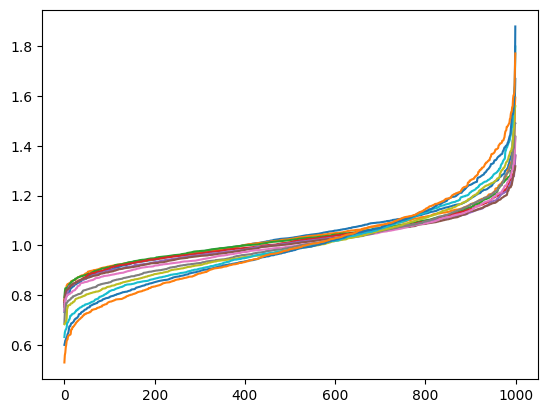

In [30]:
for i,y in enumerate(yield_list):
    pyplot.plot(numpy.sort(y))
pyplot.show()